In [6]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'
data_dir = '/Users/iaincarmichael/data/courtlistener/'

import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import rankdata
import cPickle as pickle
from collections import Counter
import pandas as pd

# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info
from viz import print_describe
from results import *

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')

from custom_vertex_metrics import *


# which network to download data for
network_name = 'federal' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

/Users/iaincarmichael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute at foreign-graphml.c:443
  if __name__ == '__main__':


# number of cases per year

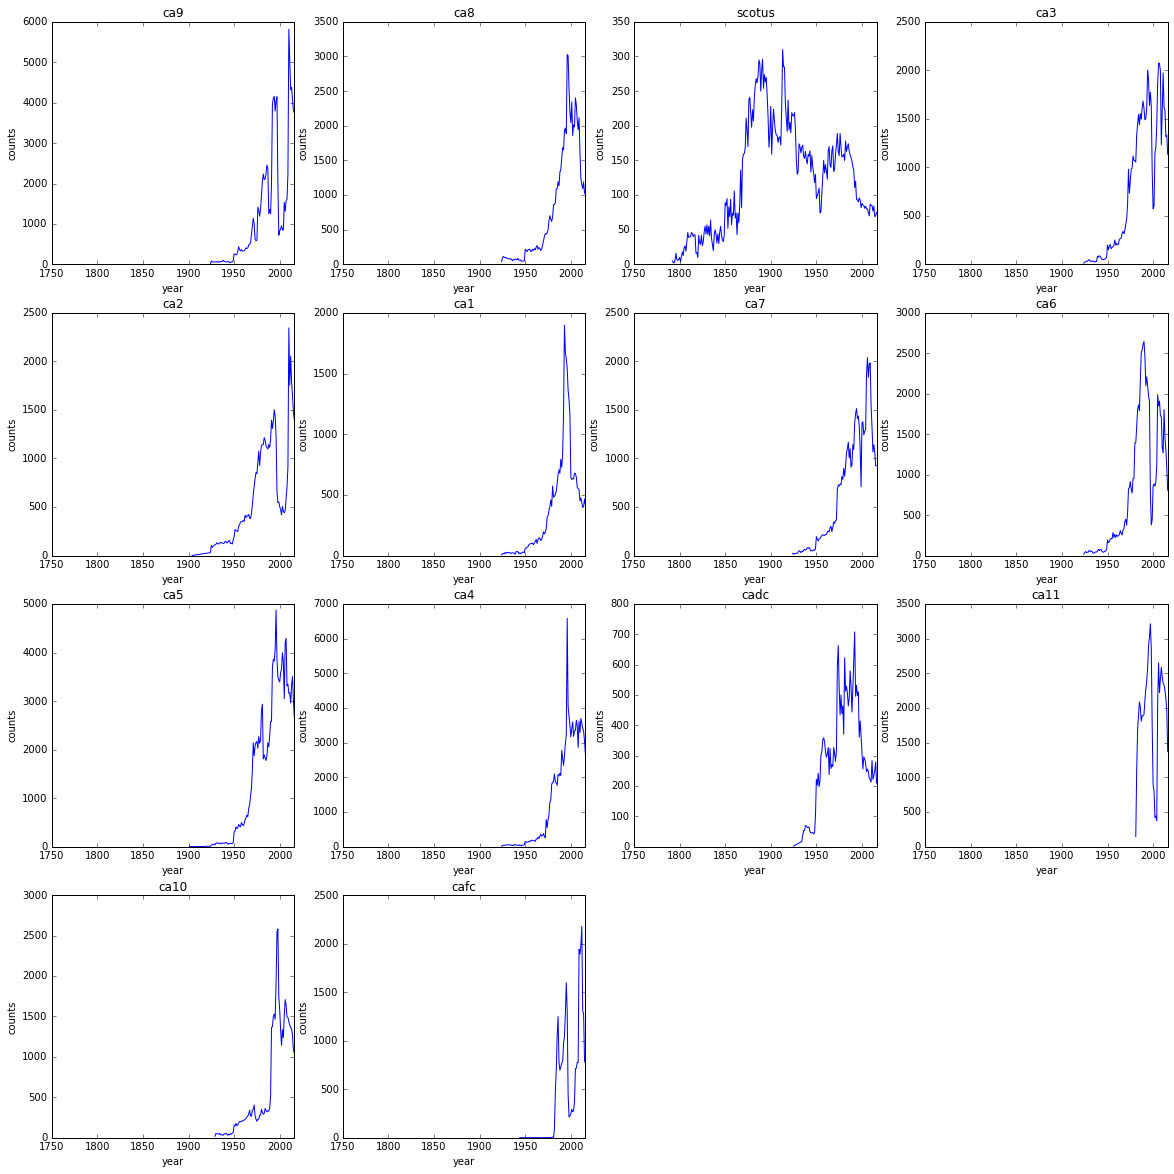

In [23]:
jurisdictions = set(G.vs['court'])

plt.figure(figsize=[20, 20])
k = 0
for court in jurisdictions:
    k += 1
    plt.subplot(4, 4, k)
    
    cases = G.vs.select(court_eq=court)

    year_counts = Counter(cases['year'])

    plt.plot(year_counts.keys(),
                year_counts.values())
    plt.xlabel('year')
    plt.xlim([1750, 2016])
    
    plt.ylabel('counts')
    plt.title(court)

# CiteRank time distribution

In [9]:
cr = get_CiteRank(G, 5.0)
years = G.vs['year']

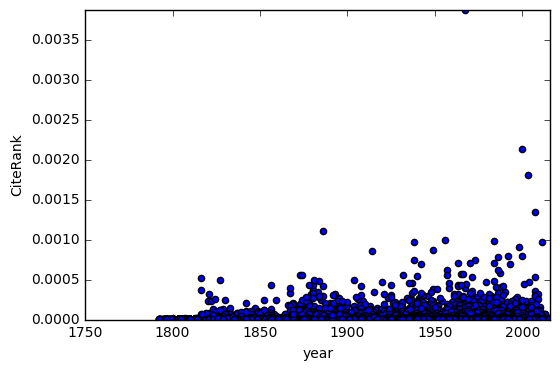

In [10]:
plt.scatter(years, cr)
plt.xlim([1750, 2016])
plt.ylim([0, 1.2 * max(cr)])

plt.ylabel('CiteRank')
plt.xlabel('year')

In [28]:
cr_by_year = {y: [] for y in set(years)}
for i in range(len(G.vs)):
    cr_by_year[years[i]].append(cr[i])
    
cr_year_mean_dict = {y: np.mean(cr_by_year[y]) for y in cr_by_year.keys()}
cr_year_mean = pd.Series(cr_year_mean_dict)

cr_year_median_dict = {y: np.median(cr_by_year[y]) for y in cr_by_year.keys()}
cr_year_median = pd.Series(cr_year_median_dict)

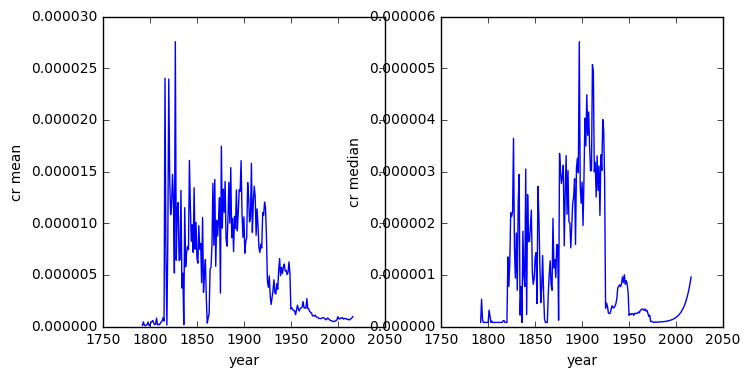

In [29]:
plt.figure(figsize=[8, 4])
plt.subplot(1,2,1)
plt.plot(cr_year_mean.index, cr_year_mean)
plt.ylabel('cr mean')
plt.xlabel('year')

plt.subplot(1,2,2)
plt.plot(cr_year_median.index, cr_year_median)
plt.ylabel('cr median')
plt.xlabel('year')

# outdegree

In [72]:
outdegree = G.outdegree()

In [77]:
print np.mean(outdegree)
print np.median(outdegree)

6.92710406933
3.0


# citation ages

In [78]:
diffs = [G.vs[e[0]]['year'] - G.vs[e[1]]['year'] for e in G.get_edgelist()]

In [86]:
print_describe(diffs)

nobs: 6649916
mean: 12.171
median: 7.000
min: -39.000
max: 220.000
std: 15.061
unique values 245


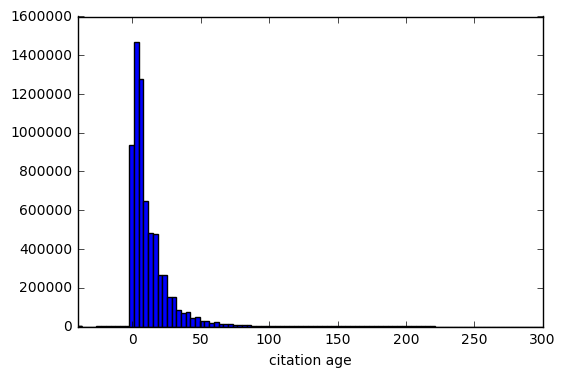

In [87]:
bins = np.linspace(-40, 300, 100)
plt.hist(diffs, bins=bins)
plt.xlim(-40, 300)
plt.xlabel('citation age')

# SCOTUS indegree

In [21]:
scotus_cases = G.vs.select(court_eq='scotus')

scotus_indegree = scotus_cases.indegree()
scotus_outdegree = scotus_cases.outdegree()
scotus_years = scotus_cases['year']

In [22]:
out_by_year = get_year_aggregate(scotus_years, scotus_outdegree, np.median)
in_by_year = get_year_aggregate(scotus_years, scotus_indegree, np.median)

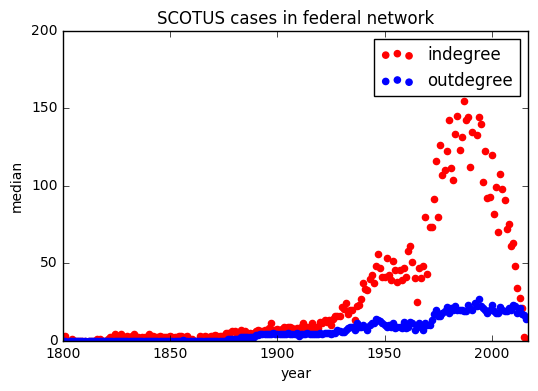

In [25]:
plt.scatter(in_by_year.index, in_by_year,
           label='indegree', color='red')
plt.scatter(out_by_year.index, out_by_year,
           label='outdegree', color='blue')
plt.ylabel('median')
plt.xlabel('year')
plt.legend(loc='upper right')
plt.xlim([1800, 2017])
plt.ylim([0, 200])
plt.title('SCOTUS cases in federal network')

# Data problems

## backward edges

In [ ]:
diffs = [G.vs[e[0]]['year'] - G.vs[e[1]]['year'] for e in G.get_edgelist()]

backward = np.where(np.array(diffs) < 0)

In [71]:
i = 10
bad_edge = G.es[backward[0][i]]

source = G.vs[bad_edge.source]
target = G.vs[bad_edge.target]

print source
case_info(source['name'])
print 
print target
case_info(target['name'])

igraph.Vertex(<igraph.Graph object at 0x119d3faf8>,345469,{'year': 1975.0, 'issueArea': nan, 'court': 'ca4', 'id': 'n345469', 'name': '373434'})
21 Fair empl.prac.cas. 895, 22 Empl. Prac. Dec. P 30,563
date_filed: 1975-06-25
https://www.courtlistener.com/opinion/373434/21-fair-emplpraccas-895-22-empl-prac-dec-p-30563/

igraph.Vertex(<igraph.Graph object at 0x119d3faf8>,309424,{'year': 1978.0, 'issueArea': nan, 'court': 'ca4', 'id': 'n309424', 'name': '360466'})
Donald L. Cale v. The City of Covington, Virginia
date_filed: 1978-11-03
https://www.courtlistener.com/opinion/360466/donald-l-cale-v-the-city-of-covington-virginia/
